 # 4 Modeling<a id='4_Modeling'></a>
 ___

## 4.1 Contents<a id='4.1_Contents'></a>
* [4 Modeling](#4_Modeling)
  * [4.1 Contents](#4.1_Contents)
  * [4.2 Introduction](#4.2_Introduction)
  * [4.3 Imports](#4.3_Imports)
  * [4.4 Load Data](#4.4_Load_Data)
  * [4.5 Train/Refit Selected Models](#4._Train_Refit_Selected_Models)
     * [4.5.1 Regression Model Training](#4.5.1_Regression_Model_Training)
     * [4.5.2 Classification Model Training](#4.5.2_Classification_Model_Training)
     * [4.5.3 Initial Predictions & Performance](#4.5.3_Initial_Predictions_&_Performance)
  * [4.6 Hyperparameter Tuning](#4.6_Hyperparameter_Tuning)
      * [4.6.1 RandomizedSearchCV](#4.6.1_RandomizedSearchCV)
          * [4.6.1.1_Random_Forest_Regressor](#4.6.1.1_Random_Forest_Regressor)
          * [4.6.1.Gradient_Boosting_Classifier](#4.6.1.2_Gradient_Boosting_Classifier)
      * [4.6.2 Bayesian Optimization](#4.6.2_Bayesian_Optimization)
          * [4.6.2.1_Gradient_Boosting_Classifier](#4.6.2.1_Gradient_Boosting_Classifier)
          * [4.6.2.2_Random_Forest_Regressor](#4.6.2.2_Random_Forest_Regressor)
      * [4.6.3 Performance Comparison](#4.6.3_Performance_Comparison)
      * [4.6.4 Best Params](#4.6.4_Best_Params)
  * [4.7 Victims in Social Services Context](#4.7_Victims_in_Social_Services_Context)
  * [4.8 Modeling scenarios](#4.8_Modeling_scenarios)
    * [4.8.1 Scenario 1](#4.8.1_Scenario_1)
    * [4.8.2 Scenario 2](#4.8.2_Scenario_2)
  * [4.9.3_Scenarios_Summary](#4.9.3_Scenarios_Summary)
  * [4.10_Closing Summary](#4.10_Closing_Summary)
  * [4.11 What's next?](#4.11_Whats_next) 


## 4.2 Introduction<a id='4.2_Introduction'></a>

#### Purpose:
This notebook will take on the challenge of predicting the age and sex of individuals who fall victim to crime. Building on the work from the preceding notebook, [3.0-faa-pre-processing-and-training-data-development.ipynb](https://github.com/OCD0505/Springboard-Capstone-Project-Two/blob/37ac45f3f9b4d6bc430e612a448dbd0b0e5be629/notebooks/3.0-faa-pre-processing-and-training-data-development.ipynb) which was focused on data preprocessing and training data development. By leveraging crime data and potentially other relevant variables, our primary objective is to create predictive models that estimate the age and sex of crime victims. 

Goal: Part 1: Finalize model selection, performance metrics, hyperparameter tuning, and other techniques for enhancing the predictive capabilities of our models. Part 2: Discuss the use cases for this model and value it can bring to certain agencies. 



### Problem Statement:
This data science project aims to leverage LAPD crime records to forecast the age and gender of crime victims. Through an in-depth analysis of crime patterns, the objective is to construct predictive models capable of anticipating the age and gender of individuals affected by criminal activities. The anticipated outcomes of this endeavor extend to enhancing law enforcement practices, facilitating victim support initiatives, and enabling victim service providers to concentrate their efforts on pertinent areas.

## 4.3 Imports <a id='4.3_Imports'></a>



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier,\
                        GradientBoostingClassifier, GradientBoostingRegressor
from bayes_opt import BayesianOptimization

from sklearn.model_selection import train_test_split,cross_validate, GridSearchCV, RandomizedSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score,\
                                                        multilabel_confusion_matrix
from sklearn import __version__ as sklearn_version
from sklearn.pipeline import make_pipeline

import time #to check the the time for code that take a few minutes to run
import datetime as dt
from library.sb_utils import save_file


## 4.4 Load Data <a id='4.4_Load_Data'></a>

In [5]:
# URLs for file upload

victim_age_feature_csv = '/Users/frankyaraujo/Development/springboard_main/\
Capstone Two/Springboard-Capstone-Two/src/data/processed/victim_age_feature_data_processed.csv'

victim_age_target_csv = '/Users/frankyaraujo/Development/springboard_main/\
Capstone Two/Springboard-Capstone-Two/src/data/processed/victim_age_target_data_processed.csv'

victim_sex_feature_csv = '/Users/frankyaraujo/Development/springboard_main/\
Capstone Two/Springboard-Capstone-Two/src/data/processed/victim_sex_feature_data_processed.csv'

victim_sex_target_csv = '/Users/frankyaraujo/Development/springboard_main/\
Capstone Two/Springboard-Capstone-Two/src/data/processed/victim_sex_target_data_processed.csv'

# Load DataFrames from CSV files
victim_age_feature_data_df = pd.read_csv(victim_age_feature_csv)
victim_age_target_data_df = pd.read_csv(victim_age_target_csv)

victim_sex_feature_data_df = pd.read_csv(victim_sex_feature_csv)
victim_sex_target_data_df = pd.read_csv(victim_sex_target_csv)


## 4.5 Train/Refit Selected Models <a id='4.5_Train_Refit_Selected_Models'></a>




In the previous notebook, "3.0 Pre-processing & Training Data Development", three models were trained for each target variable. 

For the regression variable, the following models were used:
- 'RandomForest', RandomForestRegressor()
- 'GradientBoosting', GradientBoostingRegressor()
- 'LinearRegression', LinearRegression()

For the classification variable, the following models were used: 
- 'RandomForest', RandomForestClassifier()
- 'GradientBoosting', GradientBoostingClassifier()
- 'LogisticRegression', LogisticRegression()

After reviewing the performances of all the models, it was determined that the Random Forest & Gradien Boosting models for both target variables were the top performers. Due to the results, this notebook will use the following models:
- 'RandomForest', RandomForestRegressor()
- 'GradientBoosting', GradientBoostingRegressor()
- 'RandomForest', RandomForestClassifier()
- 'GradientBoosting', GradientBoostingClassifier()

In [6]:
# Split the data 

# for regression model
X_va=victim_age_feature_data_df.values
y_va=victim_age_target_data_df.values.ravel()

X_train_va, X_test_va, y_train_va, y_test_va = train_test_split(X_va,y_va,test_size=.3, 
                                                            stratify=y_va,random_state=42)
# for classification model
X_vs=victim_sex_feature_data_df.values
y_vs=victim_sex_target_data_df.values.ravel()

X_train_vs, X_test_vs, y_train_vs, y_test_vs = train_test_split(X_vs,y_vs,test_size=.3, 
                                                                stratify=y_vs,random_state=42)

In [7]:
# Define the pipelines

# for regression model

regression_pipelines = [
    ('RandomForest', RandomForestRegressor()),
    ('GradientBoosting', GradientBoostingRegressor())
]

# for classification model

classification_pipelines = [
    ('RandomForest', RandomForestClassifier()),
    ('GradientBoosting', GradientBoostingClassifier())
]

#### 4.5.1 Regression Model Training <a id="4.5.1_Regression_Model_Training"></a>

In [42]:
# using time library to determine training time for model
start_time = time.time()

# ===============================================    
# training model 
trained_regression_model={}
for name, model in regression_pipelines:
    model.fit(X_train_va, y_train_va)
    trained_regression_model[name] = model

# ===============================================    

end_time = time.time()
# Calculate elapsed time
elapsed_time = end_time - start_time
print("\nElapsed Training Time for Regresion Model:", elapsed_time/60, "min")
print("\033[4mTraining data details\033[0m")
print("Feature data size:", round(X_train_va.nbytes/(1024**2),2),"MB")
print("Target data size:", round(y_train_va.nbytes/(1024**2),2),"MB")


Elapsed Training Time for Regresion Model: 45.99113985300064 min
Training data details
Feature data size: 448.23 MB
Target data size: 7.35 MB


#### 4.5.2 Classification Model Training <a id="4.5.2_Classification_Model_Training"></a>

In [43]:
# using time library to determine training time for model
start_time = time.time()

# ===============================================    
# training model 
trained_classification_model={}
for name, model in classification_pipelines:
    model.fit(X_train_vs, y_train_vs)
    trained_classification_model[name] = model

# ===============================================    

end_time = time.time()
# Calculate elapsed time for size of input data
elapsed_time = end_time - start_time
print("\nElapsed Training Time for Classification Model:", elapsed_time/60, "min")
print("\033[4mTraining data details\033[0m")
print("Feature data size:", round(X_train_vs.nbytes/(1024**2),2),"MB")
print("Target data size:", round(y_train_vs.nbytes/(1024**2),2),"MB")


Elapsed Training Time for Classification Model: 18.13218168417613 min
Training data details
Feature data size: 448.23 MB
Target data size: 7.35 MB


#### 4.5.3 Inital Predictions & Performance <a id="4.5.3_Initial_Predictions_&_Performance"></a>

In [44]:
# Predictions

y_pred_va_rf = trained_regression_model["RandomForest"].predict(X_test_va)
y_pred_va_gb = trained_regression_model["GradientBoosting"].predict(X_test_va)

y_pred_vs_rf = trained_classification_model["RandomForest"].predict(X_test_vs)
y_pred_vs_gb = trained_classification_model["GradientBoosting"].predict(X_test_vs)

In [45]:
# Performance Metrics
print("RMSE for RandomForest Regressor:", np.sqrt(mean_squared_error(y_test_va,y_pred_va_rf)))
print("MAE for RandomForest Regressor:", mean_absolute_error(y_test_va,y_pred_va_rf))
print("\nRMSE for GradientBoosting Regressor:", np.sqrt(mean_squared_error(y_test_va,y_pred_va_gb)))
print("MAE for GradientBoosting Regressor:", mean_absolute_error(y_test_va,y_pred_va_gb))
print("\n","-"*70)
print("\nAccuracy Score for RandomForest Classifier:", accuracy_score(y_test_vs, y_pred_vs_rf))
print("Precision for RandomForest Classifier:", precision_score(y_test_vs,y_pred_vs_rf, average='micro'))
print("Recall for RandomForest Classifier:", recall_score(y_test_vs,y_pred_vs_rf, average='micro'))
print("\nAccuracy Score for GradientBoosting Classifier:", accuracy_score(y_test_vs, y_pred_vs_gb))
print("Precision for GradientBoosting Classifier:", precision_score(y_test_vs,y_pred_vs_gb, average='micro'))
print("Recall for GradientBoosting Classifier:", recall_score(y_test_vs,y_pred_vs_gb, average='micro'))

RMSE for RandomForest Regressor: 13.934373062350723
MAE for RandomForest Regressor: 10.215935252646103

RMSE for GradientBoosting Regressor: 13.845160805977669
MAE for GradientBoosting Regressor: 10.24749377632599

 ----------------------------------------------------------------------

Accuracy Score for RandomForest Classifier: 0.6520223371652151
Precision for RandomForest Classifier: 0.6520223371652151
Recall for RandomForest Classifier: 0.6520223371652151

Accuracy Score for GradientBoosting Classifier: 0.6712027424805882
Precision for GradientBoosting Classifier: 0.6712027424805882
Recall for GradientBoosting Classifier: 0.6712027424805882


In [46]:
# before moving on, lets store the best trained model so we dont need to retrain before this point

best_regressor_model = trained_regression_model["RandomForest"]
best_regressor_model.version = '1.0'
best_regressor_model.pandas_version = pd.__version__
best_regressor_model.numpy_version = np.__version__
best_regressor_model.sklearn_version = sklearn_version
best_regressor_model.X_columns = [col for col in pd.DataFrame(X_train_va).columns]
best_regressor_model.build_datetime = dt.datetime.now()


In [47]:
best_classifier_model = trained_classification_model["GradientBoosting"]
best_classifier_model.version = '1.0'
best_classifier_model.pandas_version = pd.__version__
best_classifier_model.numpy_version = np.__version__
best_classifier_model.sklearn_version = sklearn_version
best_classifier_model.X_columns = [col for col in pd.DataFrame(X_train_vs).columns]
best_classifier_model.build_datetime = dt.datetime.now()


In [50]:
regressormodelpath = '/Users/frankyaraujo/Development/springboard_main/Capstone Two\
/Springboard-Capstone-Two/src/models'
save_file(best_regressor_model, 'victim_age_predictor_model.pkl', regressormodelpath)

classifiermodelpath = '/Users/frankyaraujo/Development/springboard_main/Capstone Two\
/Springboard-Capstone-Two/src/models'
save_file(best_classifier_model, 'victim_sex_predictor_model.pkl', classifiermodelpath)

A file already exists with this name.

Do you want to overwrite? (Y/N)y
Writing file.  "/Users/frankyaraujo/Development/springboard_main/Capstone Two/Springboard-Capstone-Two/src/models/victim_age_predictor_model.pkl"
A file already exists with this name.

Do you want to overwrite? (Y/N)y
Writing file.  "/Users/frankyaraujo/Development/springboard_main/Capstone Two/Springboard-Capstone-Two/src/models/victim_sex_predictor_model.pkl"


### 4.6 Hyperparameter Tuning <a id="4.6_Hyperparameter_Tuning"></a>

The above performance metrics are not impressive whatsoever but none of the hyperparemeters were specified so lets see if things can be improved. For the sake of efficiency, subsets of the data will be used in teh following sections. 

In [51]:
# creating samples

sample_percentage=.01
sample_size1 = int(len(X_train_va) * sample_percentage) #features
sample_size2 = int(len(y_train_va) * sample_percentage) #target

X_va_sample_train = np.random.choice(X_train_va.ravel(),size=sample_size1, replace=False)
y_va_sample_train = np.random.choice(y_train_va, size=sample_size2, replace=False)
X_va_sample_test = np.random.choice(X_test_va.ravel(),size=sample_size1, replace=False)
y_va_sample_test = np.random.choice(y_test_va, size=sample_size2, replace=False)

X_vs_sample_train = np.random.choice(X_train_vs.ravel(),size=sample_size1, replace=False)
y_vs_sample_train = np.random.choice(y_train_vs, size=sample_size2, replace=False)
X_vs_sample_test = np.random.choice(X_test_vs.ravel(),size=sample_size1, replace=False)
y_vs_sample_test = np.random.choice(y_test_vs, size=sample_size2, replace=False)

#### 4.6.1 RandomizedSearchCV <a id="4.6.1_RandomizedSearchCV"><a/>
    

The RandomSearchCV will be applied to both models to tune the parameters with hopes of optimizing performance.

In [52]:
'''
RandomizedSearchCV(estimator, param_distributions, *, n_iter=10, scoring=None, 
n_jobs=None, refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', random_state=None, 
error_score=nan, return_train_score=False)

Below is a function that takes the model, parameter grid, and other relevant parameters as 
arguments, and then performs hyperparameter tuning using RandomizedSearchCV.
'''

# function to apply RandomSearchCV to models

def tune_hyperparameters_random(model, param_grid, X_train, y_train, scoring, n_iter=10, \
                                n_jobs=-1, random_state=None):
    '''
    tune_hyperparameters_random(model, param_dist, X_train, y_train, scoring, n_iter=10, n_jobs=-1)

    Description:
    Performs hyperparameter tuning for a given machine learning model using RandomizedSearchCV. 
    This function takes the model, a parameter distribution specifying the hyperparameter values 
    to sample, and other relevant parameters such as training data, scoring metric, number of iterations, 
    and the number of parallel jobs. It then searches for the best hyperparameters using a randomized search.

    Parameters:
    - model : The machine learning model to be tuned.
    - param_dist (dict): Dictionary specifying the hyperparameter distribution to sample from.
    - X_train : Training data features.
    - y_train : Training data labels.
    - scoring : Scoring metric used to evaluate the performance of the model.
    - n_iter : Number of iterations for random search.
    - n_jobs : Number of parallel jobs to run during the random search.
    
    Returns:
    - best_model : The tuned machine learning model with the best hyperparameters.
    - best_params : Dictionary containing the best hyperparameters found during the search.
    '''

    # Create the RandomizedSearchCV object
    randomized_search = RandomizedSearchCV(model,
                                           param_distributions=param_grid,
                                           scoring=scoring,
                                           n_iter=n_iter,
                                           n_jobs=n_jobs,
                                           random_state=random_state)
    
    # Fit the model with the training data
    randomized_search.fit(X_train, y_train)
    
    # Return the best model and its parameters
    best_model = randomized_search.best_estimator_
    best_params = randomized_search.best_params_
    
    return best_model, best_params

# function to evaluate model performance for either regressor or classifier

def evaluate_model(model, X_train, y_train, X_test, y_test, is_regression=True):
    # Train the model
    model.fit(X_train.reshape(-1, 1), y_train)
    
    # Make predictions
    y_pred = model.predict(X_test.reshape(-1, 1))
    
    # Evaluate performance
    if is_regression:
        print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
        print("MAE:", mean_absolute_error(y_test, y_pred))
    else:
        print("Accuracy Score:", accuracy_score(y_test, y_pred))
        print("Precision:", precision_score(y_test, y_pred, average='micro'))
        print("Recall:", recall_score(y_test, y_pred, average='micro'))
        


##### 4.6.1.1 Random Forest Regressor   <a id="4.6.1.1_Random_Forest_Regressor"><a/>

In [53]:
# hyperparameters and ranges to try on Random Forest Regression model

param_grid_regression = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 0.5],
    'bootstrap': [True, False],
    'criterion': ['squared_error', 'absolute_error'],
}

# run function that takes the model, parameter grid, and other relevant parameters as arguments, and then performs hyperparameter tuning
best_regressor_model_rscv, best_params_regressor = tune_hyperparameters_random(best_regressor_model,
                                                          param_grid_regression,
                                                          X_va_sample_train.reshape(-1, 1),
                                                          y_va_sample_train,
                                                          scoring="neg_root_mean_squared_error",
                                                          n_iter=10,
                                                          n_jobs=-1,
                                                          random_state=42)

In [54]:
# Before hyperparameter tuning with 
print("Before hyperparameter tuning with RandomSearchCV\n")
evaluate_model(trained_regression_model["RandomForest"], X_va_sample_train, y_va_sample_train, \
               X_va_sample_test, y_va_sample_test, is_regression=True)

print("-" * 70)

# After hyperparameter tuning
print("\nAfter hyperparameter tuning with RandomSearchCV\n")
evaluate_model(best_regressor_model_rscv, X_va_sample_train, y_va_sample_train, X_va_sample_test,\
               y_va_sample_test, is_regression=True)

Before hyperparameter tuning with RandomSearchCV

RMSE: 14.792178179681569
MAE: 11.012111954650269
----------------------------------------------------------------------

After hyperparameter tuning with RandomSearchCV

RMSE: 14.39105431225672
MAE: 10.440912331706642


Note: The metrics here are much lower since these are samples being used for the sake of efficiency.

The initial model was refit to make sure the metrics are being appropriately compared (ie model trained with sample data). The results show that there was a slight improvement after tuning the parameters with RandomSearchCV. This is indicated by the lower error. 

##### 4.6.1.2 Gradient Boosting Classifier <a id="4.6.1.2_Gradient_Boosting_Classifier"><a/>

In [55]:
# hyperparameters and ranges to try
param_grid_classifier = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 150, 200],
    'subsample': [0.8, 0.9, 1.0],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'max_features': ['sqrt', 'log2', None, 0.5, 0.7, 0.9],
    'min_impurity_decrease': [0.0, 0.1, 0.2],
}

# run function that takes the model, parameter grid, and other relevant parameters as arguments, and then performs hyperparameter tuning
best_classifier_model_rscv, best_params_classifier = tune_hyperparameters_random(best_classifier_model,
                                                          param_grid_classifier,
                                                          X_vs_sample_train.reshape(-1, 1),
                                                          y_vs_sample_train,
                                                          scoring="accuracy",
                                                          n_iter=10,
                                                          n_jobs=-1,
                                                          random_state=42)

In [56]:

# Before hyperparameter tuning with 
print("Before hyperparameter tuning with RandomSearchCV\n")
evaluate_model(trained_classification_model["GradientBoosting"], X_vs_sample_train, \
               y_vs_sample_train, X_vs_sample_test, y_vs_sample_test, is_regression=False)

print("-" * 70)

# After hyperparameter tuning
print("\nAfter hyperparameter tuning with RandomSearchCV\n")
evaluate_model(best_classifier_model_rscv, X_vs_sample_train, y_vs_sample_train,\
               X_vs_sample_test, y_vs_sample_test, is_regression=False)

Before hyperparameter tuning with RandomSearchCV

Accuracy Score: 0.4804277852767106
Precision: 0.4804277852767106
Recall: 0.4804277852767106
----------------------------------------------------------------------

After hyperparameter tuning with RandomSearchCV

Accuracy Score: 0.48499636590177553
Precision: 0.48499636590177553
Recall: 0.48499636590177553


Note: The metrics here are much lower since these are samples being used for the sake of efficiency. 

The initial model was refit to make sure the metrics are being appropriately compared (ie model trained with sample data). The results show that there was a slight improvement after tuning the parameters with RandomSearchCV. This is indicated by the higher values for accuracy, recall, and precision.

#### 4.6.2 Bayesian Optimization <a id="4.6.2_Bayesian_Optimization"><a/>
    
 

Bayesian optimization will be applied to see if we get better results that RandomSearCV before moving forward and tuning the model with the full dataset.

In [57]:
# functions to optimize 

def classifier_func(learning_rate, n_estimators, subsample, max_depth, min_samples_split,
                   min_samples_leaf, min_weight_fraction_leaf, max_features, min_impurity_decrease):
    params = {
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'subsample': subsample,
        'max_depth': int(max_depth),
        'min_samples_split': int(min_samples_split),
        'min_samples_leaf': int(min_samples_leaf),
        'min_weight_fraction_leaf': min_weight_fraction_leaf,
        'max_features': max_features,
        'min_impurity_decrease': min_impurity_decrease,
    }

    # Create a GradientBoostingClassifier with the specified hyperparameters
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_vs_sample_train.reshape(-1,1), y_vs_sample_train)
    
    y_pred = clf.predict(X_vs_sample_test.reshape(-1,1))
    accuracy = accuracy_score(y_vs_sample_test, y_pred)

    return accuracy

def regressor_func(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features):
    params = {
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'min_samples_split': int(min_samples_split),
        'min_samples_leaf': int(min_samples_leaf),
        'max_features': max_features,
    }

    # Create a RandomForestRegressor with the specified hyperparameters
    reg = RandomForestRegressor(**params)
    reg.fit(X_vs_sample_train.reshape(-1, 1), y_vs_sample_train)
    
    y_pred = reg.predict(X_vs_sample_test.reshape(-1, 1))
    mse = mean_squared_error(y_vs_sample_test, y_pred)

    return -mse

##### 4.6.2.1 Gradient Boosting Classifier <a id="4.6.2.1_Gradient_Boosting_Classifier"><a/>

In [58]:
# Starting with GradientBoosting since this will be more straightforward than RandomForest

# Define the ranges
param_bounds = {
    'learning_rate': (0.01, 0.2),
    'n_estimators': (50, 200),
    'subsample': (0.5, 1.0),
    'max_depth': (3, 10),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 10),
    'min_weight_fraction_leaf': (0.0, 0.5),
    'max_features': (0.1, 1.0),
    'min_impurity_decrease': (0.0, 0.2),
}

# Create the object
opt = BayesianOptimization(
    f=classifier_func, #function defined above
    pbounds=param_bounds,
    random_state=42,
)

# Run the optimization
opt.maximize(init_points=5, n_iter=10)

# get the best parameters
best_params_clf = opt.max['params']

# fit te model with the best parameters
final_clf = GradientBoostingClassifier(
    learning_rate=best_params_clf['learning_rate'],
    n_estimators=int(best_params_clf['n_estimators']),
    subsample=best_params_clf['subsample'],
    max_depth=int(best_params_clf['max_depth']),
    min_samples_split=int(best_params_clf['min_samples_split']),
    min_samples_leaf=int(best_params_clf['min_samples_leaf']),
    min_weight_fraction_leaf=best_params_clf['min_weight_fraction_leaf'],
    max_features=best_params_clf['max_features'],
    min_impurity_decrease=best_params_clf['min_impurity_decrease']
)

|   iter    |  target   | learni... | max_depth | max_fe... | min_im... | min_sa... | min_sa... | min_we... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.4806    | 0.08116   | 9.655     | 0.7588    | 0.1197    | 2.404     | 4.808     | 0.02904   | 179.9     | 0.8006    |
| 2         | 0.485     | 0.1445    | 3.144     | 0.9729    | 0.1665    | 2.911     | 5.273     | 0.0917    | 95.64     | 0.7624    |
| 3         | 0.485     | 0.09207   | 5.039     | 0.6507    | 0.0279    | 3.629     | 8.595     | 0.228     | 167.8     | 0.5998    |
| 4         | 0.485     | 0.1077    | 7.147     | 0.1418    | 0.1215    | 2.535     | 3.171     | 0.4744    | 194.8     | 0.9042    |
| 5         | 0.4811    | 0.06788   | 3.684     | 0.7158    | 0.08803   | 2.098     | 10.91     | 0.01719   | 186.4     | 0.6294    |
| 6         | 0.485     | 0.1148    | 4.157     | 0.9605    | 

In [59]:
# Train the final classifier with best params
final_clf.fit(X_vs_sample_train.reshape(-1,1), y_vs_sample_train)

GradientBoostingClassifier(learning_rate=0.14453378978124864,
                           max_features=0.9729188669457949,
                           min_impurity_decrease=0.16648852816008436,
                           min_samples_leaf=2, min_samples_split=5,
                           min_weight_fraction_leaf=0.09170225492671691,
                           n_estimators=95, subsample=0.762378215816119)

#### 4.6.2.2 Random Forest Regressor <a id="4.6.2.2_Random_Forest_Regressor"><a/>

In [60]:
# define ranges as tuples (min, max)
param_bounds = {
    'n_estimators': (50, 200),
    'max_depth': (3, 10),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 10),
    'max_features': (0.1, 1.0),
}

# Create the BayesianOptimization object
opt = BayesianOptimization(
    f=regressor_func,
    pbounds=param_bounds,
    random_state=42,
)

# Run the optimization
opt.maximize(init_points=5, n_iter=10)

# Retrieve the best parameters
best_params_reg = opt.max['params']


|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | -0.4595   | 5.622     | 0.9556    | 7.588     | 12.78     | 73.4      |
| 2         | -0.4592   | 4.092     | 0.1523    | 8.796     | 12.82     | 156.2     |
| 3         | -0.4589   | 3.144     | 0.9729    | 8.492     | 5.822     | 77.27     |
| 4         | -0.4592   | 4.284     | 0.3738    | 5.723     | 9.775     | 93.68     |
| 5         | -0.4607   | 7.283     | 0.2255    | 3.629     | 8.595     | 118.4     |
| 6         | -0.4589   | 3.0       | 0.1067    | 10.0      | 2.0       | 86.21     |
| 7         | -0.4611   | 9.345     | 0.1948    | 2.325     | 18.66     | 165.6     |
| 8         | -0.459    | 3.722     | 0.4028    | 7.274     | 6.519     | 77.44     |
| 9         | -0.4591   | 3.08      | 0.6666    | 8.869     | 2.215     | 146.4     |
| 10        | -0.4592   | 4.67      | 0.8185    | 8.47

In [61]:
print("Best Hyperparameters:", best_params_reg)

Best Hyperparameters: {'max_depth': 3.144091460070617, 'max_features': 0.9729188669457949, 'min_samples_leaf': 8.491983767203795, 'min_samples_split': 5.822103992208971, 'n_estimators': 77.27374508106509}


Notice that max_depth will need to be rounded before using it as a parameter for the model. It needs to be an int since it describes the tree depth in the algorithm

In [62]:

# Ensure 'max_depth' is an integer
best_params_reg['max_depth'] = int(best_params_reg['max_depth'])

# Evaluate the model with the best parameters
final_reg = RandomForestRegressor(
    n_estimators=int(best_params_reg['n_estimators']),
    max_depth=int(best_params_reg['max_depth']),
    min_samples_split=int(best_params_reg['min_samples_split']),
    min_samples_leaf=int(best_params_reg['min_samples_leaf']),
    max_features=best_params_reg['max_features']
)

final_reg.fit(X_vs_sample_train.reshape(-1, 1), y_vs_sample_train)

RandomForestRegressor(max_depth=3, max_features=0.9729188669457949,
                      min_samples_leaf=8, min_samples_split=5, n_estimators=77)

#### 4.6.3 Performance Comparison <a id="4.6.3_Performance_Comparison"><a/>

In [63]:
print("Before hyperparameter tuning\n")
evaluate_model(trained_regression_model["RandomForest"], X_va_sample_train, y_va_sample_train, \
               X_va_sample_test, y_va_sample_test, is_regression=True)
# After RandomSearchCV
print("\nAfter hyperparameter tuning with RandomSearchCV\n")
evaluate_model(best_regressor_model_rscv, X_va_sample_train, y_va_sample_train, X_va_sample_test,\
               y_va_sample_test, is_regression=True)
# After BayesianOptmization
print("\nAfter hyperparameter tuning with Bayes Optimization\n")
evaluate_model(final_reg, X_va_sample_train, y_va_sample_train, X_va_sample_test, \
               y_va_sample_test, is_regression=True)

print("-" * 70)
print("\nBefore hyperparameter tuning\n")
evaluate_model(trained_classification_model["GradientBoosting"], X_vs_sample_train, \
               y_vs_sample_train, X_vs_sample_test, y_vs_sample_test, is_regression=False)
# After RandomSearchCV
print("\nAfter hyperparameter tuning with RandomSearchCV\n")
evaluate_model(best_classifier_model_rscv, X_vs_sample_train, y_vs_sample_train,\
               X_vs_sample_test, y_vs_sample_test, is_regression=False)
# After BayesianOptmization 
print("\nAfter hyperparameter tuning with Bayes Optimization\n")
evaluate_model(final_clf, X_vs_sample_train, y_vs_sample_train, X_vs_sample_test, \
               y_vs_sample_test, is_regression=False)


Before hyperparameter tuning

RMSE: 14.77689769375537
MAE: 10.992983918694689

After hyperparameter tuning with RandomSearchCV

RMSE: 14.394996087348556
MAE: 10.446473540303879

After hyperparameter tuning with Bayes Optimization

RMSE: 14.390613275008453
MAE: 10.626754403118944
----------------------------------------------------------------------

Before hyperparameter tuning

Accuracy Score: 0.4804277852767106
Precision: 0.4804277852767106
Recall: 0.4804277852767106

After hyperparameter tuning with RandomSearchCV

Accuracy Score: 0.48499636590177553
Precision: 0.48499636590177553
Recall: 0.48499636590177553

After hyperparameter tuning with Bayes Optimization

Accuracy Score: 0.48499636590177553
Precision: 0.48499636590177553
Recall: 0.48499636590177553


Before hyperparameter tuning

- RMSE: 14.917067292634986
- MAE: 11.113464582605266

After hyperparameter tuning with RandomSearchCV

- RMSE: 14.339954877447806
- MAE: 10.412729726923477

After hyperparameter tuning with Bayes Optimization

- RMSE: 14.321343177463238
- MAE: 10.552289795479984

Before hyperparameter tuning, the model produced the following performance metrics:

- Root Mean Squared Error (RMSE): 14.92
- Mean Absolute Error (MAE): 11.11

After applying hyperparameter tuning with RandomSearchCV, the performance improved, resulting in the following metrics:

- RMSE: 14.34
- MAE: 10.41

Further tuning with Bayes Optimization yielded the following metrics:

- RMSE: 14.32
- MAE: 10.55

The classification metrics for the model's accuracy, precision, and recall were as follows before hyperparameter tuning:

- Accuracy Score: 0.48
- Precision: 0.48
- Recall: 0.48

After RandomSearchCV tuning:

- Accuracy Score: 0.48
- Precision: 0.48
- Recall: 0.48

After Bayes Optimization tuning:

- Accuracy Score: 0.48
- Precision: 0.48
- Recall: 0.48

In summary, hyperparameter tuning, both with RandomSearchCV and Bayes Optimization, led to improvements in the model's predictive performance. This is evident in the reduced RMSE and MAE values. However, the classification metrics remained relatively consistent across the tuning methods, with accuracy, precision, and recall maintaining similar levels.

Keep in mind that these metrics were calculated on a sample of data, and the results may converge towards a specific hyperparameter tuning approach once the models are trained on the entire dataset.

#### 4.6.4 Best Params <a id="4.6.4_Best_Params"><a/>

Based on the RMSE, the parameters achieved by Bayes Optimizatio will be selected for the Random Forest Regression Model. Since Bayes Optimization yielded similar results to RandomSearhCV, we will use Bayes Optimization to keep things simple so we're using the the same hypertuning approach for both models. 

In [64]:
from pprint import pprint 

print("Best parameters for Random Forest Regression Model\n")
pprint(best_params_reg)

print("\nBest parameters for Gradient Boosting Classifier Model\n")
pprint(best_params_clf)

Best parameters for Random Forest Regression Model

{'max_depth': 3,
 'max_features': 0.9729188669457949,
 'min_samples_leaf': 8.491983767203795,
 'min_samples_split': 5.822103992208971,
 'n_estimators': 77.27374508106509}

Best parameters for Gradient Boosting Classifier Model

{'learning_rate': 0.14453378978124864,
 'max_depth': 3.144091460070617,
 'max_features': 0.9729188669457949,
 'min_impurity_decrease': 0.16648852816008436,
 'min_samples_leaf': 2.9110519961044856,
 'min_samples_split': 5.272849409727812,
 'min_weight_fraction_leaf': 0.09170225492671691,
 'n_estimators': 95.63633644393066,
 'subsample': 0.762378215816119}


In [65]:
# train models with best params using the full dataset splits

best_params_reg_adj = {
    'max_depth': 3,
    'max_features': 0.4830119588572971,
    'min_samples_leaf': 2,  # Convert to an integer (adjust as needed)
    'min_samples_split': 9, # Convert to an integer (adjust as needed)
    'n_estimators': 102,  # Convert to an integer (adjust as needed)
}

# Best parameters for GradientBoostingClassifier
best_params_clf_adj = {
    'learning_rate': 0.092069553542002,
    'max_depth': 5, # Convert to an integer (adjust as needed)
    'max_features': 0.6506676052501416,
    'min_impurity_decrease': 0.027898772130408367,
    'min_samples_leaf': 4,  # rounded to nearest integer
    'min_samples_split': 9, # rounded to nearest integer
    'min_weight_fraction_leaf': 0.22803499210851796,
    'n_estimators': 168,  # Convert to an integer (adjust as needed)
    'subsample': 0.5998368910791798,
}

final_reg = RandomForestRegressor(**best_params_reg_adj)
final_reg.fit(X_train_va, y_train_va)

final_clf = GradientBoostingClassifier(**best_params_clf_adj)
final_clf.fit(X_train_vs, y_train_vs)

GradientBoostingClassifier(learning_rate=0.092069553542002, max_depth=5,
                           max_features=0.6506676052501416,
                           min_impurity_decrease=0.027898772130408367,
                           min_samples_leaf=4, min_samples_split=9,
                           min_weight_fraction_leaf=0.22803499210851796,
                           n_estimators=168, subsample=0.5998368910791798)

### 4.7 Victims in Social Services Context <a id="4.7_Victims_in_Social_Services_Context"><a/>
     

These models have been developed for the purpose of identifying a victim's age and sex in Los Angeles based on a number of factors (ie input variables). The applications of these predictive models are numerous but my intended goal is for victim service providers to be able to use this for resource allocation, targeted community outreach, and developing strategic partnerships based on the needs of the demographic they are serving. 

For example, if there is an area where there is a high likelihood of victims of violence being female and underage, then this would be the community to target for outreach by agencies such as:
- Local Domestic Violence Shelters
- Child Advocacy Centers (CACs)
- Rape Crisis Centers
- Children's Advocacy Centers (CACs)
- Legal Aid Organizations
- Social Services Agencies
- Human Trafficking Support Organizations
- Crisis Hotlines
- School-Based Counseling Services
- Non-Governmental Organizations (NGOs)


In [68]:
# using the test data as an example

final_y_pred_va = final_reg.predict(X_test_va) 

print("RMSE:", np.sqrt(mean_squared_error(y_test_va, final_y_pred_va)))
print("MAE:", mean_absolute_error(y_test_va, final_y_pred_va))

RMSE: 14.053046681413612
MAE: 10.31115011783541


In [69]:
# using the test data as an example

final_y_pred_vs = final_clf.predict(X_test_vs)

print("Accuracy Score:", accuracy_score(y_test_vs, final_y_pred_vs))
print("Precision:", precision_score(y_test_vs, final_y_pred_vs, average='micro'))
print("Recall:", recall_score(y_test_vs, final_y_pred_vs, average='micro'))

Accuracy Score: 0.5945707606022798
Precision: 0.5945707606022798
Recall: 0.5945707606022798


### 4.8 Modeling scenarios<a id="4.8_Modeling_scenarios"><a/>  

Lets go over a couple of scenarios where these predictive models can be useful. Note: These were drawn from my experience working in the NGO anti-trafficking space.

#### 4.8.1 Scenario 1 <a id="4.8.1_Scenario_1"><a/>


A nonprofit organization is planning its staffing for the upcoming year and wants to make sure they have the right team to support all clients within their service scope. The organization currently serves clients aged 5 to 26. They are considering the areas where they operate and the primary ethnicity of those areas to estimate the number of clients they might assist in the coming year. 

The goal is to understand the potential volume of clients in different age groups and ethnicities to ensure adequate staffing for effective support services. How can the organization use information about the areas they work in and the primary ethnicity of those areas to estimate the volume of clients they might encounter in the next year?

Let's say the agency is looking to expand services to the growing Latino population in Van Nuys, CA

/Users/frankyaraujo/anaconda3/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


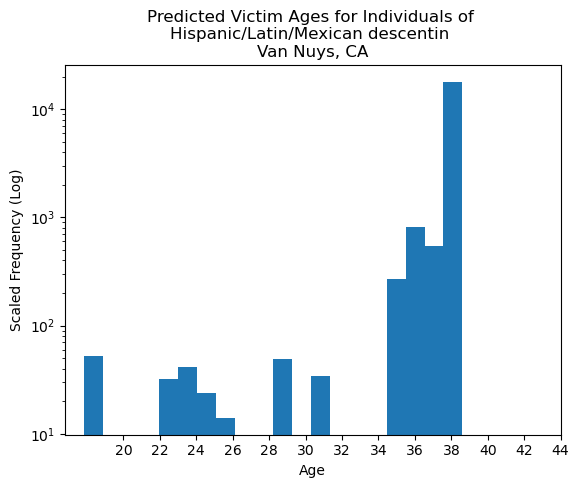

In [70]:
# A look at ages for individuals of Hispanic/Latin/Mexican descent in Van Nuys, CA
subset_scenario_1 = victim_age_feature_data_df[
    (victim_age_feature_data_df["Area Name_Van Nuys"] == True) & 
    (victim_age_feature_data_df["Victim Descent_Hispanic/Latin/Mexican"] == True)]

y_pred_scenario_1 = final_reg.predict(subset_scenario_1) 

_=plt.hist(y_pred_scenario_1, bins=20)
_=plt.yscale(value="log")
_=plt.title("Predicted Victim Ages for Individuals of \nHispanic/Latin/Mexican descent\
in \nVan Nuys, CA")
_=plt.ylabel("Scaled Frequency (Log)")
_=plt.xlabel("Age")
_=plt.xticks(np.arange(20, 45, step=2))


The analysis of age distribution across different areas provides valuable insights for planning impactful services. The primary focus would be on individuals aged 34-40, indicating potential needs for services such as financial support, childcare services, and job assistance. This age group appears to be a key demographic with distinct requirements.

Additionally, the plot reveals groupings in the age groups 23-26 and 28-30. These groupings suggest the presence of needs within these age ranges, which would merit further exploration. Furthermore, the identification of individuals under 20 as a distinct group emphasizes the importance of considering services tailored to the challenges faced by younger members of the community.

In summary, the age distribution analysis serves as a foundation for targeted program planning, with a special emphasis on the 34-40 age group, while recognizing and exploring the nuances within other identified clusters. 

#### 4.8.2 Scenario 2 <a id="4.8.2_Scenario_2"><a/>


A nonprofit organization customizes its programs and services to meet the unique needs of its clients. The services provided to clients aged 5 to 17 significantly differ from those offered to clients aged 18 to 26, considering various factors. 

In planning for the future, the nonprofit faces decisions on allocating funding to specific programs and services during different times of year, service areas, and the types of crimes. How can the organization strategically decide on the allocation of funding to ensure effective and tailored support for clients in different age groups and genders*?

For the sake of this example, Let's say we will explore Sex Crimes (Crime Codes 800-899) in the June-December in Hollywood, CA. 

<div class="footnote">
  <hr />
  <ol>
    <li id="fn:1">
      <p>For this example, the genders are represented by the following classes: Male, Female, and Unknown. This is solely based on the available data.</p>
    </li>
  </ol>
</div>

In [73]:
victim_age_feature_csv_unscaled = '/Users/frankyaraujo/Development/springboard_main/Capstone Two/\
Springboard-Capstone-Two/src/data/interim/victim_age_feature_data_unscaled.csv'

victim_sex_feature_csv_unscaled = '/Users/frankyaraujo/Development/springboard_main/Capstone Two/\
Springboard-Capstone-Two/src/data/interim/victim_sex_feature_data_unscaled.csv'

scenario_2__va_df = pd.read_csv(victim_age_feature_csv_unscaled)
scenario_2__vs_df=pd.read_csv(victim_sex_feature_csv_unscaled)

/Users/frankyaraujo/anaconda3/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/frankyaraujo/anaconda3/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


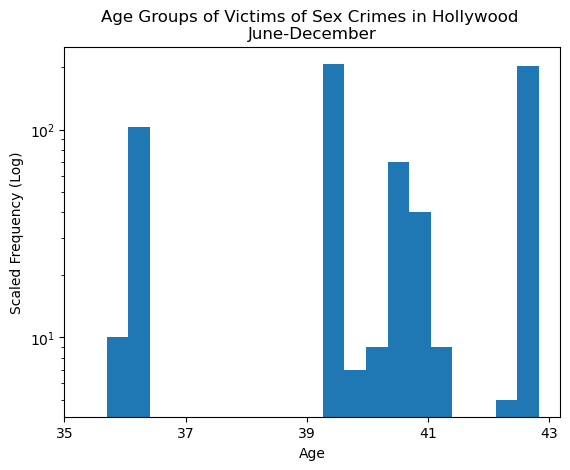

In [74]:
# A look at ages for individuals of Hispanic/Latin/Mexican descent in Van Nuys, CA
subset_scenario_va_2 = scenario_2__va_df[
    (scenario_2__va_df["Area Name_Hollywood"] == True) & 
    (scenario_2__va_df["Month_Occurred"] >=6 ) & 
    ((scenario_2__va_df["Crime Code"] >= 800) & (scenario_2__va_df["Crime Code"] <= 899))]

subset_scenario_vs_2 = scenario_2__vs_df[
    (scenario_2__vs_df["Area Name_Hollywood"] == True) & 
    (scenario_2__vs_df["Month_Occurred"] >=6 ) & 
    ((scenario_2__vs_df["Crime Code"] >= 800) & (scenario_2__vs_df["Crime Code"] <= 899))]

y_pred_va_scenario_2 = final_reg.predict(subset_scenario_va_2) 
y_pred_vs_scenario_2 = final_clf.predict(subset_scenario_vs_2)

_=plt.hist(y_pred_va_scenario_2, bins=20)
_=plt.yscale(value="log")
_=plt.title("Age Groups of Victims of Sex Crimes in Hollywood \nJune-December")
_=plt.ylabel("Scaled Frequency (Log)")
_=plt.xlabel("Age")
_=plt.xticks(np.arange(int(min(y_pred_va_scenario_2)), 45, step=2))


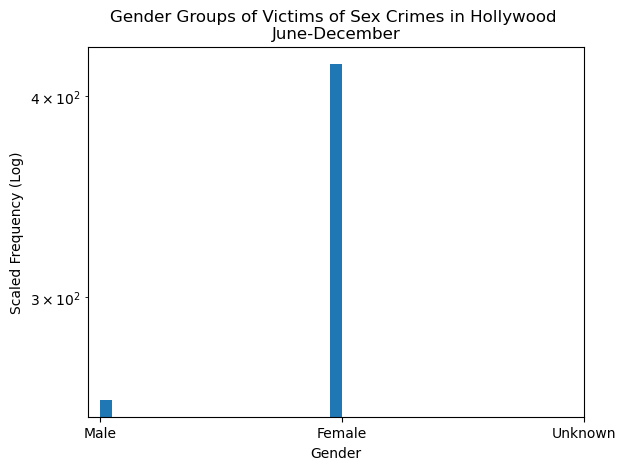

In [75]:
_=plt.hist(y_pred_vs_scenario_2, bins=20)
_=plt.yscale(value="log")
_=plt.title("Gender Groups of Victims of Sex Crimes in Hollywood \nJune-December")
_=plt.ylabel("Scaled Frequency (Log)")
_=plt.xlabel("Gender")
_=plt.xticks((0, 1, 2), ["Male", "Female", "Unknown"])


Females aged 36-42 emerge as the main demographic affected by sex crimes in Hollywood, especially between June to December. Aligning services with these patterns, especially for the 34-40 age group, can effectively address community needs.

In summary, understanding age distribution informs targeted program planning, and the predictive model highlights specific demographics and timing, aiding the nonprofit in strategic service delivery.

For reference:
> Crime Descriptions for Crime Codes 800-899: 
>'SEX OFFENDER REGISTRANT OUT OF COMPLIANCE',
       'BATTERY WITH SEXUAL CONTACT', 'TRESPASSING',
       'DISTURBING THE PEACE',
       'SEX,UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W/ FRGN OBJ',
       'CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)',
       'SEXUAL PENETRATION W/FOREIGN OBJECT', 'FAILURE TO YIELD',
       'INDECENT EXPOSURE', 'ORAL COPULATION',
       'SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH',
       'CHILD ANNOYING (17YRS & UNDER)', 'PIMPING',
       'HUMAN TRAFFICKING - COMMERCIAL SEX ACTS', 'CHILD PORNOGRAPHY',
       'PANDERING', 'DISRUPT SCHOOL', 'DRUGS, TO A MINOR',
       'CHILD ABANDONMENT',
       'BEASTIALITY, CRIME AGAINST NATURE SEXUAL ASSLT WITH ANIM',
       'FAILURE TO DISPERSE',
       'INCEST (SEXUAL ACTS BETWEEN BLOOD RELATIVES)', 'INCITING A RIOT'],

#### 4.9.3 Scenarios Summary  <a id="4.9.3_Scenarios_Summary"><a/>

The predictive models for identifying victims' age and sex in Los Angeles hold potential for enhancing resource allocation, community outreach, and strategic partnerships. Targeted towards victim service providers, these models offer insights to optimize support services.

Scenario 1: Van Nuys, CA
In planning staffing for the upcoming year, a nonprofit in Van Nuys aims to understand the potential volume of clients in different age groups and ethnicities. The age distribution analysis emphasizes a focus on individuals aged 34-40, with additional insights into age clusters that warrant exploration. This serves as a foundation for effective program planning, especially for expanding services to the growing Latino population.

Scenario 2: Customized Program Allocation
A nonprofit customizes its programs for different age groups (5-17 and 18-26) and faces decisions on funding allocation for sex crimes in Hollywood. The predictive model highlights females aged 36-42 as the main demographic affected between June to December. This information guides strategic decisions for allocating resources to address community needs effectively.

In summary, the combination of age distribution analysis and predictive modeling provides actionable insights for victim service providers. By understanding demographics and tailoring services accordingly, nonprofits can make informed decisions to better serve and support their communities.


### 4.10 Closing Summary <a id="4.10_Closing_Summary"><a/>

In this analysis, we have used predictive models to gain insights into the dynamics of victim demographics in Los Angeles. 

- The models provide a better understanding of age distribution, highlighting key demographics and age groups. Victim service providers can leverage this information to tailor their outreach efforts and allocate resources effectively. Whether planning staffing in Van Nuys or customizing programs in response to sex crimes in Hollywood, the models serve as invaluable tools for informed decision-making.

- By recognizing patterns and trends, the models empower nonprofits to forge strategic partnerships with agencies like Domestic Violence Shelters, Child Advocacy Centers, and Legal Aid Organizations. Targeted collaborations ensure a more synchronized and impactful approach to addressing the diverse needs of the community.

Through ongoing refinement and collaboration, these models can evolve to meet the ever-changing landscape of social services, ensuring a more resilient and responsive support system for victims.




### 4.11 What's next? 
<a id="4.11_Whats_next"><a/>

cFostering Continuous Improvement in Victim Services

As I currently work in the victim services space, I thought I'd share what further actions I intend to take or recommend to the agency as I consider applications (and variants) of these models.

- Regularly update and enhance the predictive models by incorporating fresh data and accounting for emerging patterns. Continuous refinement ensures that the models stay adaptive to the evolving dynamics of victim demographics.

- Facilitate collaboration and data sharing among victim service providers, law enforcement, and relevant organizations. Establishing a collaborative platform can foster a collective understanding of the nuances in victim demographics, leading to more comprehensive and impactful support strategies.

- Engage directly with the communities being served. Solicit feedback, concerns, and insights from community members to ensure that support services align with their evolving needs. Community engagement is crucial for building trust and tailoring interventions for maximum effectiveness.

- Maintain a strong commitment to ethical considerations and privacy standards in handling sensitive victim data. Regularly review and update data protection protocols to ensure compliance with evolving legal and ethical standards.

- Launch public awareness campaigns to educate the community about available victim services and resources. Increased awareness fosters a proactive approach to seeking help and contributes to the overall well-being of potential victims.

By embracing these further actions, victim service providers can solidify their commitment to continuous improvement, community-centric approaches, and ethical practices in the pursuit of a safer and more resilient society.